<a href="https://colab.research.google.com/github/Palaeoprot/ModulAAR/blob/main/main_fitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install nbimporter

In [2]:
# prompt: authenticate colab OAuth client c

from google.colab import auth, drive
auth.authenticate_user()
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


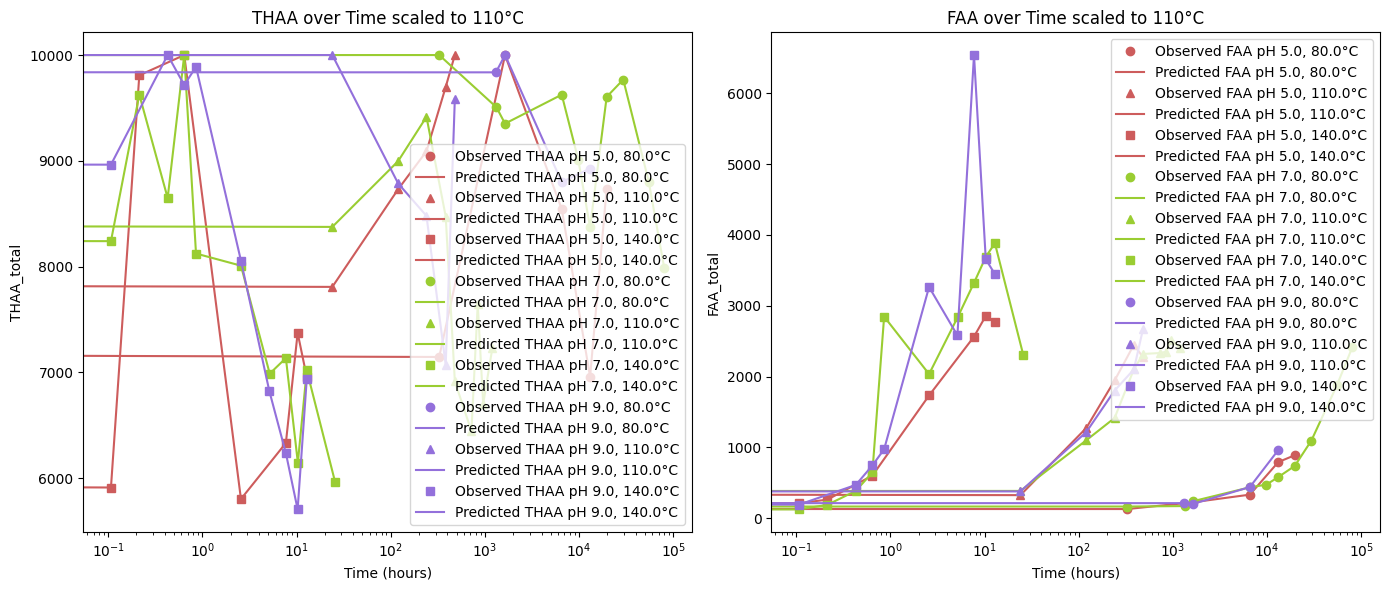

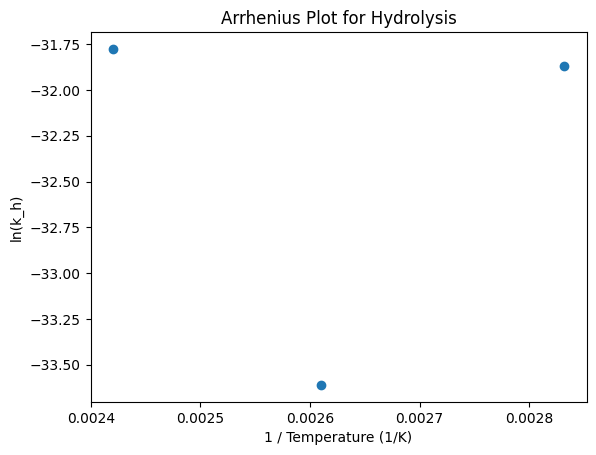

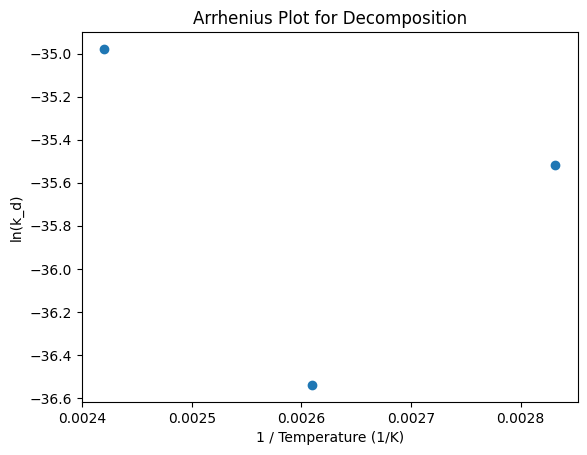

In [3]:
import nbformat
from IPython import get_ipython
import gspread
from google.auth.transport.requests import Request
from google.colab import auth
from google.auth import default
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from datetime import datetime
import os
import pickle


R = 8.314  # Gas constant in J/(mol·K)

def execute_notebook(notebook_path):
    """Execute a Jupyter notebook and return its namespace."""
    with open(notebook_path, 'r', encoding='utf-8') as f:
        nb = nbformat.read(f, as_version=4)

    namespace = {}
    for cell in nb.cells:
        if cell.cell_type == 'code':
            exec(cell.source, namespace)
    return namespace

def fit_decomposition_rate(data, temperatures, times):
    """Fit the decomposition rate based on the total loss of amino acids, assuming second-order reaction."""
    def objective(k_d):
        residuals = []
        for temp in temperatures:
            temp_data = data[data['temp (°C)'] == temp]
            for t in times:
                observed_THAA = temp_data[temp_data['time'] == t]['THAA_total'].values
                if len(observed_THAA) == 0:
                    continue
                A0 = observed_THAA[0]
                predicted_THAA = A0 / (1 + k_d * A0 * t)
                residuals.append(predicted_THAA - observed_THAA[0])
        return np.array(residuals).flatten()

    initial_k_d = 1e-7
    result = least_squares(objective, initial_k_d, bounds=(0, np.inf))
    return result.x[0]

def fit_hydrolysis_rate(data, temperatures, times, k_d):
    """Fit the hydrolysis rate after adjusting for decomposition, assuming second-order reaction."""
    def objective(k_h):
        residuals = []
        for temp in temperatures:
            temp_data = data[data['temp (°C)'] == temp]
            for t in times:
                observed_FAA = temp_data[temp_data['time'] == t]['FAA_total'].values
                if len(observed_FAA) == 0:
                    continue
                A0 = observed_FAA[0]
                predicted_FAA = A0 / (1 + k_h * A0 * t)
                residuals.append(predicted_FAA - observed_FAA[0])
        return np.array(residuals).flatten()

    initial_k_h = 1e-6
    result = least_squares(objective, initial_k_h, bounds=(0, np.inf))
    return result.x[0]

def scale_to_reference_temp(data, ref_temp, activation_energy=98000):
    """Scale data to a reference temperature using the Arrhenius equation."""
    ref_temp_K = ref_temp + 273.15
    scaled_data = data.copy()

    for index, row in data.iterrows():
        temp_K = row['temp (°C)'] + 273.15
        scaling_factor = np.exp(-activation_energy * (1 / ref_temp_K - 1 / temp_K) / R)
        scaled_data.at[index, 'time'] *= scaling_factor

    return scaled_data

def optimise_rates(data):
    """Optimize hydrolysis and decomposition rates for each pH level separately."""
    pH_levels = data['pH'].unique()
    optimized_parameters = []

    for pH in pH_levels:
        pH_data = data[data['pH'] == pH]
        temperatures = pH_data['temp (°C)'].unique()
        times = pH_data['time'].unique()

        k_d_opt = fit_decomposition_rate(pH_data, temperatures, times)
        k_h_opt = fit_hydrolysis_rate(pH_data, temperatures, times, k_d_opt)

        optimized_parameters.append((pH, k_h_opt, k_d_opt))

    return optimized_parameters

def plot_results(data, optimized_parameters, ref_temp=110):
    """Plot observed and predicted THAA and FAA concentrations for each pH level."""
    scaled_data = scale_to_reference_temp(data, ref_temp)
    pH_levels = scaled_data['pH'].unique()
    temperature_symbols = {80: 'o', 110: '^', 140: 's'}
    pH_colors = {5: 'indianred', 7: 'yellowgreen', 9: 'mediumpurple'}

    plt.figure(figsize=(14, 6))

    for pH, k_h, k_d in optimized_parameters:
        pH_data = scaled_data[scaled_data['pH'] == pH]
        temperatures = pH_data['temp (°C)'].unique()

        for temp in temperatures:
            T = temp + 273.15
            temp_data = pH_data[pH_data['temp (°C)'] == temp]
            observed_THAA = temp_data['THAA_total']
            observed_FAA = temp_data['FAA_total']
            time = temp_data['time']

            predicted_THAA = observed_THAA / (1 + k_d * observed_THAA * time)
            predicted_FAA = observed_FAA / (1 + k_h * observed_FAA * time)

            plt.subplot(1, 2, 1)
            plt.plot(time, observed_THAA, temperature_symbols[temp], color=pH_colors[pH], label=f'Observed THAA pH {pH}, {temp}°C')
            plt.plot(time, predicted_THAA, '-', color=pH_colors[pH], label=f'Predicted THAA pH {pH}, {temp}°C')

            plt.subplot(1, 2, 2)
            plt.plot(time, observed_FAA, temperature_symbols[temp], color=pH_colors[pH], label=f'Observed FAA pH {pH}, {temp}°C')
            plt.plot(time, predicted_FAA, '-', color=pH_colors[pH], label=f'Predicted FAA pH {pH}, {temp}°C')

    plt.subplot(1, 2, 1)
    plt.xscale('log')
    plt.xlabel('Time (hours)')
    plt.ylabel('THAA_total')
    plt.title(f'THAA over Time scaled to {ref_temp}°C')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.xscale('log')
    plt.xlabel('Time (hours)')
    plt.ylabel('FAA_total')
    plt.title(f'FAA over Time scaled to {ref_temp}°C')
    plt.legend()

    plt.tight_layout()
    plt.show()

def load_data(file_path):
    """Load data from a CSV file."""
    return pd.read_csv(file_path)

def write_data(sheet_id, gid, rows):
    """Write data to Google Sheets using OAuth 2.0 Client ID."""
    SCOPES = ['https://www.googleapis.com/auth/spreadsheets']
    auth.authenticate_user()
    creds, _ = default()
    client = gspread.authorize(creds)
    # Use get_worksheet_by_id() instead of worksheet_by_id()
    sheet = client.open_by_key(sheet_id).get_worksheet_by_id(int(gid)) # gid needs to be an integer

    for row in rows:
        sheet.append_row(row)

def prepare_data_for_google_sheets(optimized_parameters):
    """Prepare data to be written to Google Sheets."""
    rows = [['pH', 'k_h', 'k_d']]
    for params in optimized_parameters:
        rows.append([params[0], params[1], params[2]])
    return rows

def arrhenius_plot(temps, rate_constants, title, ylabel):
    """Generate an Arrhenius plot."""
    inverse_temps = 1 / (temps + 273.15)  # Convert to Kelvin and take the inverse
    log_rate_constants = np.log(rate_constants)

    plt.figure()
    plt.plot(inverse_temps, log_rate_constants, 'o')
    plt.xlabel('1 / Temperature (1/K)')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

def main():
    data_path = '/content/drive/MyDrive/Colab_Notebooks/MoDuLAAR/ProcessedData/real_DL_summed_totals.csv'
    data = load_data(data_path)

    if data.empty:
        print("Data is empty. Please check the data file.")
        return

    optimized_parameters = optimise_rates(data)

    rows = prepare_data_for_google_sheets(optimized_parameters)
    sheet_id = '1nA6jSAkAf1Ud-kHdaYTMtBPgKhe9nBg_IjM9idLlj8E'
    gid = '1475619581'
    write_data(sheet_id, gid, rows)

    plot_results(data, optimized_parameters)

    temperatures = data['temp (°C)'].unique()
    k_h_values = [params[1] for params in optimized_parameters]
    k_d_values = [params[2] for params in optimized_parameters]
    arrhenius_plot(temperatures, k_h_values, 'Arrhenius Plot for Hydrolysis', 'ln(k_h)')
    arrhenius_plot(temperatures, k_d_values, 'Arrhenius Plot for Decomposition', 'ln(k_d)')

if __name__ == '__main__':
    main()
